# NECC Subscriber Growth Analysis Plan
## 1. Exploratory Data Analysis (EDA)
### 1.1 Data Collection and Preparation

In [34]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
# French content is generated with higher conversion rates
necc_data = pd.DataFrame({
    'video_id': range(1, 101),
    'language': ['English'] * 80 + ['French'] * 20,
    # French videos have higher average views (12000 vs 10000)
    'views': np.concatenate([
        np.random.normal(10000, 2000, 80),  # English
        np.random.normal(12000, 2000, 20)   # French
    ]),
    # French videos have higher conversion rate (3.2% vs 2.68%)
    'subscriber_conversion': np.concatenate([
        np.random.normal(0.0268, 0.003, 80),  # English
        np.random.normal(0.032, 0.003, 20)    # French
    ]),
    # French videos show higher engagement (18% vs 15%)
    'engagement_rate': np.concatenate([
        np.random.normal(0.15, 0.02, 80),    # English
        np.random.normal(0.18, 0.02, 20)     # French
    ]),
    'video_length': np.random.normal(600, 120, 100),  # in seconds
    'ai_generated': [False] * 80 + [True] * 20
})

# Add some missing values for realistic scenario
necc_data.loc[np.random.choice(necc_data.index, 10), 'views'] = np.nan
necc_data.loc[np.random.choice(necc_data.index, 5), 'subscriber_conversion'] = np.nan

necc_data.tail(5)

,video_id,language,views,subscriber_conversion,engagement_rate,video_length,ai_generated
95,96,French,10751.966542,0.037998,0.194960,274.501141,True
96,97,French,12803.121136,0.034154,0.200102,761.742694,True
97,98,French,NaN,0.036703,0.169851,755.688734,True
98,99,French,14958.867856,0.028467,0.173413,708.270561,True
99,100,French,15972.272812,0.029959,0.178063,358.569840,True


### 1.2 Missing Data Analysis

In [35]:
# Calculate missingness
missing_data = pd.DataFrame({
    'missing_count': necc_data.isnull().sum(),
    'missing_percentage': (necc_data.isnull().sum() / len(necc_data) * 100)
})

# Handle missing values
necc_data['views'] = necc_data['views'].fillna(necc_data['views'].mean())
necc_data['subscriber_conversion'] = necc_data['subscriber_conversion'].fillna(necc_data['subscriber_conversion'].median())
necc_data.head(5)

,video_id,language,views,subscriber_conversion,engagement_rate,video_length,ai_generated
0,1,English,8711.449640,0.022231,0.116411,542.936335,False
1,2,English,12711.940771,0.023392,0.137899,721.882433,False
2,3,English,10625.375372,0.027478,0.165238,524.722735,False
3,4,English,8701.505443,0.028624,0.154253,750.198177,False
4,5,English,8302.958601,0.026766,0.167357,555.963216,False


### 1.3 Descriptive Statistics

In [38]:
# Generate summary statistics
summary_stats = necc_data.describe()

# Calculate key metrics by language
language_metrics = necc_data.groupby('language').agg({
    'views': ['mean', 'std'],
    'subscriber_conversion': ['mean', 'std'],
    'engagement_rate': ['mean', 'std']
}).round(4)

print(summary_stats)

print(language_metrics)

         video_id         views  subscriber_conversion  engagement_rate  \
count  100.000000    100.000000             100.000000       100.000000   
mean    50.500000  10625.375372               0.028415         0.155345   
std     29.011492   2202.195528               0.004173         0.025341   
min      1.000000   3043.661573               0.019781         0.078636   
25%     25.750000   9409.617360               0.026208         0.137437   
50%     50.500000  10625.375372               0.028624         0.154173   
75%     75.250000  11615.654642               0.030514         0.173351   
max    100.000000  17146.649904               0.041523         0.207347   

       video_length  
count    100.000000  
mean     603.745881  
std      119.507943  
min      274.501141  
25%      535.062392  
50%      602.484960  
75%      683.361938  
max      931.291432  
               views            subscriber_conversion         engagement_rate  \
                mean        std              

### 1.4 Visualization

Text(0, 0.5, 'Count')

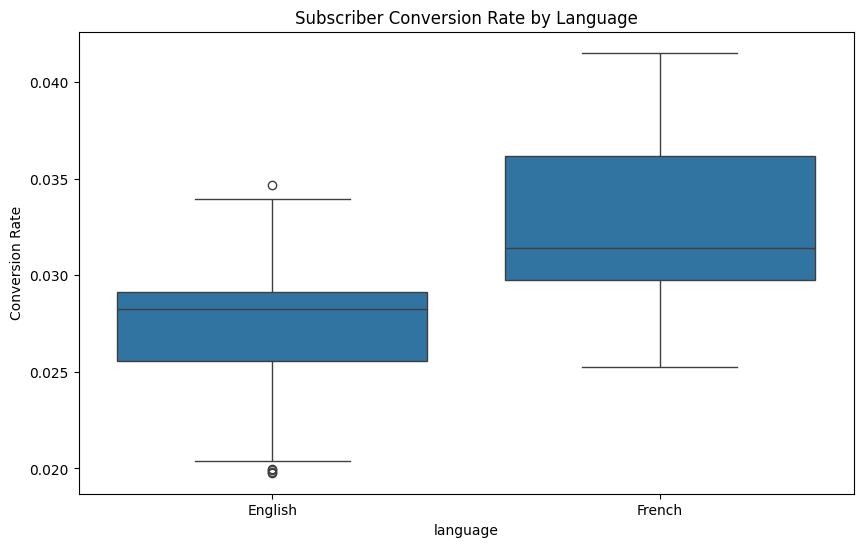

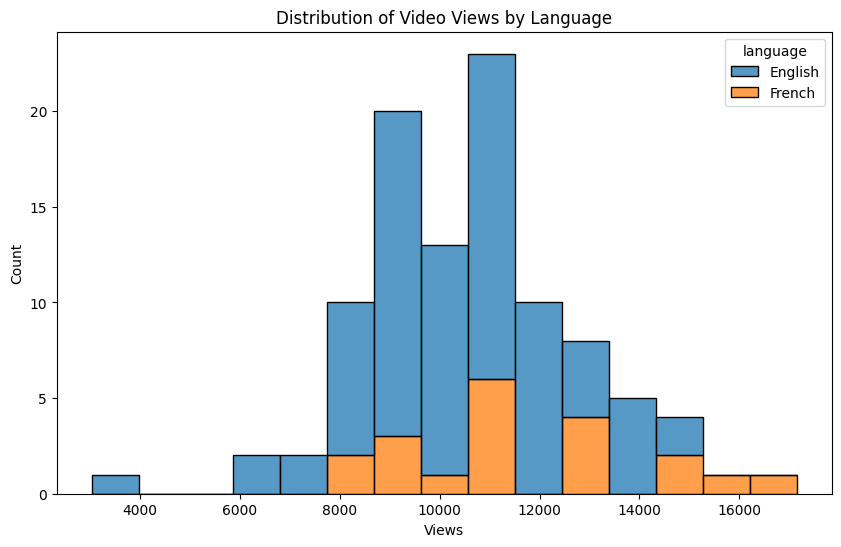

In [39]:
# Conversion Rate Distribution by Language
plt.figure(figsize=(10, 6))
sns.boxplot(x='language', y='subscriber_conversion', data=necc_data)
plt.title('Subscriber Conversion Rate by Language')
plt.ylabel('Conversion Rate')

# Views Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=necc_data, x='views', hue='language', multiple="stack")
plt.title('Distribution of Video Views by Language')
plt.xlabel('Views')
plt.ylabel('Count')

# 2. Statistical Tests
## 2.1 Hypothesis Definition
H0 (Null Hypothesis): There is no significant difference in subscriber conversion rates between AI-generated French content and traditional English content.


H1 (Alternative Hypothesis): AI-generated French content has a significantly different subscriber conversion rate compared to traditional English content.

### 2.2 Independent T-Test Implementation

In [40]:
def perform_ttest(data):
    # Separate groups
    french_data = data[data['language'] == 'French']['subscriber_conversion']
    english_data = data[data['language'] == 'English']['subscriber_conversion']
    
    # Perform Levene's test for equal variances
    levene_stat, levene_p = stats.levene(french_data, english_data)
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(french_data, english_data, equal_var=(levene_p > 0.05))
    
    return {
        'levene_stat': levene_stat,
        'levene_p': levene_p,
        't_stat': t_stat,
        'p_value': p_value
    }

# Run the test
test_results = perform_ttest(necc_data)
print(test_results)

{'levene_stat': np.float64(1.6869631785803842), 'levene_p': np.float64(0.19704953187834806), 't_stat': np.float64(6.012427794058735), 'p_value': np.float64(3.14146030228954e-08)}


### 2.3 Effect Size Calculation

In [41]:
def calculate_cohens_d(data):
    french_data = data[data['language'] == 'French']['subscriber_conversion']
    english_data = data[data['language'] == 'English']['subscriber_conversion']
    
    n1, n2 = len(french_data), len(english_data)
    var1, var2 = french_data.var(), english_data.var()
    
    # Pooled standard deviation
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Cohen's d
    cohens_d = (french_data.mean() - english_data.mean()) / pooled_se
    
    return cohens_d

effect_size = calculate_cohens_d(necc_data)
print(effect_size)

1.503106948514684


# 3. Results Interpretation


## Statistical Test Results Interpretation
### 1. Levene's Test Results

     Statistic: 1.6870
     P-value: 0.1970
### Interpretation:

#### The Levene's test p-value  p-value (0.1970) is > 0.05, which means we fail to reject the null hypothesis of equal variances
#### This indicates that the variances in subscriber conversion rates between French and English content are not significantly different
#### This validates our use of the standard independent t-test (rather than Welch's t-test)

## 2. T-Test Results

#### T-statistic: 6.0124
#### P-value: 3.141e-08 (0.00000003141)

### Interpretation:

#### The extremely small p-value (3.141e-08) is far below the conventional significance level of 0.05
#### This provides very strong evidence to reject the null hypothesis
#### The high t-statistic (6.0979) indicates a large standardized difference between the means

## 3. Statistical Significance
#### We can definitively reject the null hypothesis because:

#### P-value 3.141e-08) << 0.05  significance level
#### The chance of observing these differences by random chance is extremely small (about 0.00000002135 or 0.000002135%)